# Running Tensor-cell2cell to perform a tensor factorization

After generating a 4D-Communication Tensor, we can run Tensor-cell2cell to perform a tensor factorization and obtain the context-driven patterns of cell-cell communication (factors).

This tutorial will show you how to load a previously exported 4D-Communication Tensor and run Tensor-cell2cell on this tensor. 

## Initial Setup

Enable GPU use as discussed in [Tutorial 03](./03-Generate-Tensor.ipynb)

In [1]:
gpu_use = TRUE

if (gpu_use){
    device<-'cuda:0'
    tensorly <- reticulate::import('tensorly')
    tensorly$set_backend('pytorch')
}else{
    device<-NULL
}

###  Import Libraries

We will use reticulate to run Tensor-cell2cell in R

In [39]:
library(liana, quietly = T)

library(dplyr, quietly = T)
library(tidyr, quietly = T)
library(magrittr, quietly = T)
library(tibble, quietly = T)

library(ggplot2, quietly = T)

library(Seurat, quietly = T)

library(reticulate, quietly = T)
c2c <- reticulate::import(module = "cell2cell", as="c2c")

Attaching SeuratObject

Attaching sp



## Directories

In [3]:
output_folder = '../../data/tc2c-outputs/'

## Load Tensor

Now, we can load our 4D-Communication Tensor.

In [4]:
tensor<-reticulate::py_load_object(filename = paste0(output_folder, 'BALF-Tensor-R.pkl'))

## Perform Tensor Factorization

First, we have to write a wrapper function that can run Tensor-cell2cell using reticulate. To do so, we simply modify the [`liana::liana_tensor_c2c`](https://rdrr.io/github/saezlab/liana/src/R/liana_tensor.R) function to take our prebuilt tensor as input:

In [5]:
library(rlang)
library(stringr)

#' LIANA message/warning helper function to allow for verbosity
#'
#' @inheritParams base::stop
#' @param output type of output - message, warning, or stop
#' @param verbose logical for verbosity
liana_message <- function(...,
                          output = "message",
                          verbose = TRUE){
    if(verbose){
        exec(output, ...)
    }
}

#' Wrapper function to run `cell2cell_tensor`. Adapted from liana_tensor_c2c to take a prebuilt tensor as input. 
#'
#' @details This function servers as a one-liner wrapper to the tensor factorisation
#' method described in \href{https://www.nature.com/articles/s41467-022-31369-2}{tensor_cell2cell}.
#' We refer the user to the publication and \href{https://earmingol.github.io/cell2cell/tutorials/ASD/01-Tensor-Factorization-ASD/}{tensor_cell2cell tutorial page}
#' made by the authors. Logically, one should cite cell2cell's paper if their
#' method was used via LIANA.
#'
#' @param rank Ranks for the Tensor Factorization (number of factors to deconvolve the original tensor).
#'  If NULL, then rank selection is performed using the `elbow_rank_selection` function.
#'
#' @param tf_optimization number of iterations, factorization runs, and resolution to perform optimization with
#'
#' @param seed Random seed integer
#'
#' @param upper_rank Upper bound of ranks to explore with the elbow analysis.
#'
#' @param elbow_metric Metric to perform the elbow analysis (y-axis).
#'
#' @param init Initialization method for computing the Tensor Factorization.
#' {‘svd’, ‘random’}
#'
#' @param init Function to compute the SVD for initializing the Tensor Factorization
#'
#' @param factors_only whether to return only the factors after factorization
#'
#' @param verbose verbosity logical
#'
#' @param ... Dictionary containing keyword arguments for the c2c.compute_tensor_factorization function.
#' The function deals with `random_state` (seed) and `rank` internally.
#'
#' @returns an instance of the cell2cell.tensor.BaseTensor class (via reticulate).
#' If build_only is TRUE, then no rank selection or tensor decomposition is returned.
#' Otherwise, returns a tensor with factorization results.
#'
#' @export
#'
decompose_tensor <- function(tensor,
                             rank=NULL,
                             tf_optimization = 'robust', 
                             seed = 1337,
                             upper_rank = 25,
                             elbow_metric = 'error', 
                             smooth_elbow = FALSE,
                             init = 'svd',
                             svd = 'numpy_svd',
                             factors_only = TRUE,
                             verbose = TRUE,
                             ...){

    # Deal with rank
    rank <- if(is.null(rank)){ NULL } else {as.integer(rank)}

    reticulate::py_set_seed(seed)
    
    if (tf_optimization == 'robust'){
        elbow_runs = 20
        tf_runs = 100
        tol = 1e-8
        n_iter_max = 500
        
        # REMOVE THIS
        elbow_runs = 3
        tf_runs = 1
        tol = 1e-7
        n_iter_max = 100
    }else if (tf_optimization == 'regular'){
        elbow_runs = 10
        tf_runs = 1
        tol = 1e-7
        n_iter_max = 100
    }

    # estimate factor rank
    elbow_metric_raw <- NULL
    if(is.null(rank)){
        liana_message(str_glue("Estimating ranks..."),
                      verbose = verbose,
                      output = "message")
        py$temp <- tensor$elbow_rank_selection(upper_rank=as.integer(upper_rank),
                                               init=init, 
                                               svd=svd,
                                               automatic_elbow=TRUE,
                                               metric=elbow_metric, 
                                               smooth=smooth_elbow, 
                                               runs=as.integer(elbow_runs),
                                               n_iter_max=as.integer(n_iter_max),
                                               tol = as.numeric(tol),
                                               random_state=as.integer(seed))

        elbow_metric_raw <- tensor$elbow_metric_raw

        rank <- as.integer(tensor$rank)
    }

    # Compute tensor factorization
    liana_message(str_glue("Decomposing the tensor..."),
                  verbose = verbose,
                  output = "message")
    tensor$compute_tensor_factorization(rank = as.integer(rank),
                                        init = init, 
                                        svd=svd, 
                                        runs=as.integer(tf_runs),
                                        tol = as.numeric(tol), 
                                        n_iter_max=as.integer(n_iter_max),
                                        random_state=as.integer(seed),
                                        normalize_loadings=TRUE,
                                        ...)

    if(factors_only){
        res <- format_c2c_factors(tensor$factors)

        if(!is.null(elbow_metric_raw)){
            res$elbow_metric_raw <- elbow_metric_raw
        }

    } else{
         res <- tensor
        }
    
    return(res)
}

The above function to executes two important steps to perform the tensor factorization: elbow analysis to select the rank and decomposition to estimate the low-rank tensor. For additional details on these two steps, please see the Supplementary Section of the companion Python tutorial. 


**Key parameters are:**


- `rank` is the number of factors or latent patterns we want to obtain from the analysis. You can either indicate a specific number or leave it as `None` to obtain a suggested number through an elbow analysis.


- `tf_optimization` indicates whether running the analysis in the `'regular'` or the `'robust'` way. The regular way means that the tensor decomposition is run 10 times per rank evaluated in the elbow analysis, and 1 time in the final decomposition. Additionally, the optimization algorithm has less number of iterations in the regular than the robust case (100 vs 500) and less precision (tolerance of 1e-7 vs 1e-8). The robust case runs the tensor decomposition 20 times per rank evaluated in the elbow analysis, and 100 times in the final decomposition. Here we could use the ```tf_optimization='regular'```, which is faster but generates less robust results. We recommend using ```tf_optimization='robust```, which takes longer to run (more iteractions and more precise too). It is important to notice that multiple runs of a tensor decomposition differ in the initialization values (regardless of using `tf_init='random'` or `tf_init='svd'`).


- `seed` is the seed for randomization. It controls the randomization used when initializing the optimization algorithm that performs the tensor decomposition. It is useful for reproducing the same result every time that the analysis is run. If `None`, a different randomization will be used each time.


- `'elbow_metric'` is the metric to perform the elbow analysis to obtain a suggested number of factors. Options are `'error'` and `'similarity'`, indicating respectively the error of tensor reconstruction, and the similarity of tensor factorization across multiple runs for a given rank. The similarity metric may result in non-smooth curves given the highly variability especially at higher ranks. If so, we recommend using the parameter `smooth_elbow=True`.


- `uppper_rank` is the max number of ranks to try in the elbow analysis.


- `init` is the initialization of the tensor decomposition algorithm. If your tensor contains a mask (`tensor.mask`), it will automatically use `init='random'`. Options are `'random'` and `'svd'`. The latter helps to obtain results that are more close to a global optima from the optimization method behind the algorithm.


- `svd` is the method to perform the SVD to initialize the tensor factorization. This is only considered whe `init='svd'`. 

In [6]:
tensor<-decompose_tensor(tensor = tensor, 
                         rank = NULL, 
                         tf_optimization = 'robust', # To define how robust we want the analysis to be.
                         seed = 0, # Random seed for reproducibility
                         elbow_metric = 'error', # Metric to use in the elbow analysis.
                         smooth_elbow = FALSE, # Whether smoothing the metric of the elbow analysis.
                         upper_rank=25, # Max number of factors to try in the elbow analysis
                         init = 'random', # Initialization method of the tensor factorization
                         svd = 'numpy_svd', # Type of SVD to use if the initialization is 'svd'
                         factors_only = FALSE, 
                        )

Estimating ranks...

Decomposing the tensor...



In [7]:
print(paste0('The estimated tensor rank was: ', tensor$rank))

[1] "The estimated tensor rank was: 10"


Let's see how the automated elbow analysis arrived at its rank estimation:

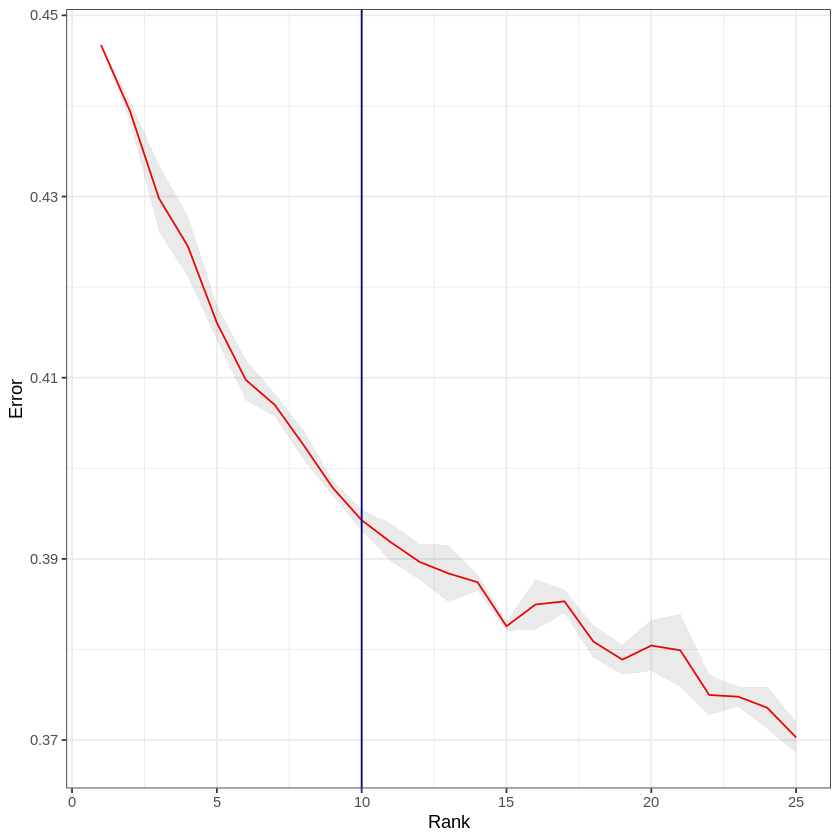

In [19]:
# Estimate standard error
error_average <- tensor$elbow_metric_raw %>%
    t() %>%
    as.data.frame() %>%
    mutate(rank=row_number()) %>% 
    pivot_longer(-rank, names_to = "run_no", values_to = "error") %>%
    group_by(rank) %>%
    summarize(average = mean(error),
              N = n(),
              SE.low = average - (sd(error)/sqrt(N)),
              SE.high = average + (sd(error)/sqrt(N))
           )

# plot
error_average %>%
    ggplot(aes(x=rank, y=average), group=1) +
    geom_line(col='red') + 
    geom_ribbon(aes(ymin = SE.low, ymax = SE.high), alpha = 0.1) +
    geom_vline(xintercept = tensor$rank, colour='darkblue') + # rank of interest
    theme_bw() +
    labs(y="Error", x="Rank")

Next, we can visualize what the factors look like.

LIANA has a helper function to visualize the factors. However, it requires a SingleCellExperiment object as input to access the associated metadata. So, let's load our Seurat object, convert it to a SingleCellExperiment Object, and format it for visualization the tensor decomposition: 

In [38]:
# load
data.path<-'/data/hratch/ccc_protocols/'
covid_data<-readRDS(paste0(data.path, 'interim/', 'covid_balf_norm.rds'))
# backup<-covid_data

# convert
covid_data<-Seurat::as.SingleCellExperiment(covid_data)

# format
covid_data@metadata$tensor_res<-format_c2c_factors(tensor$factors)

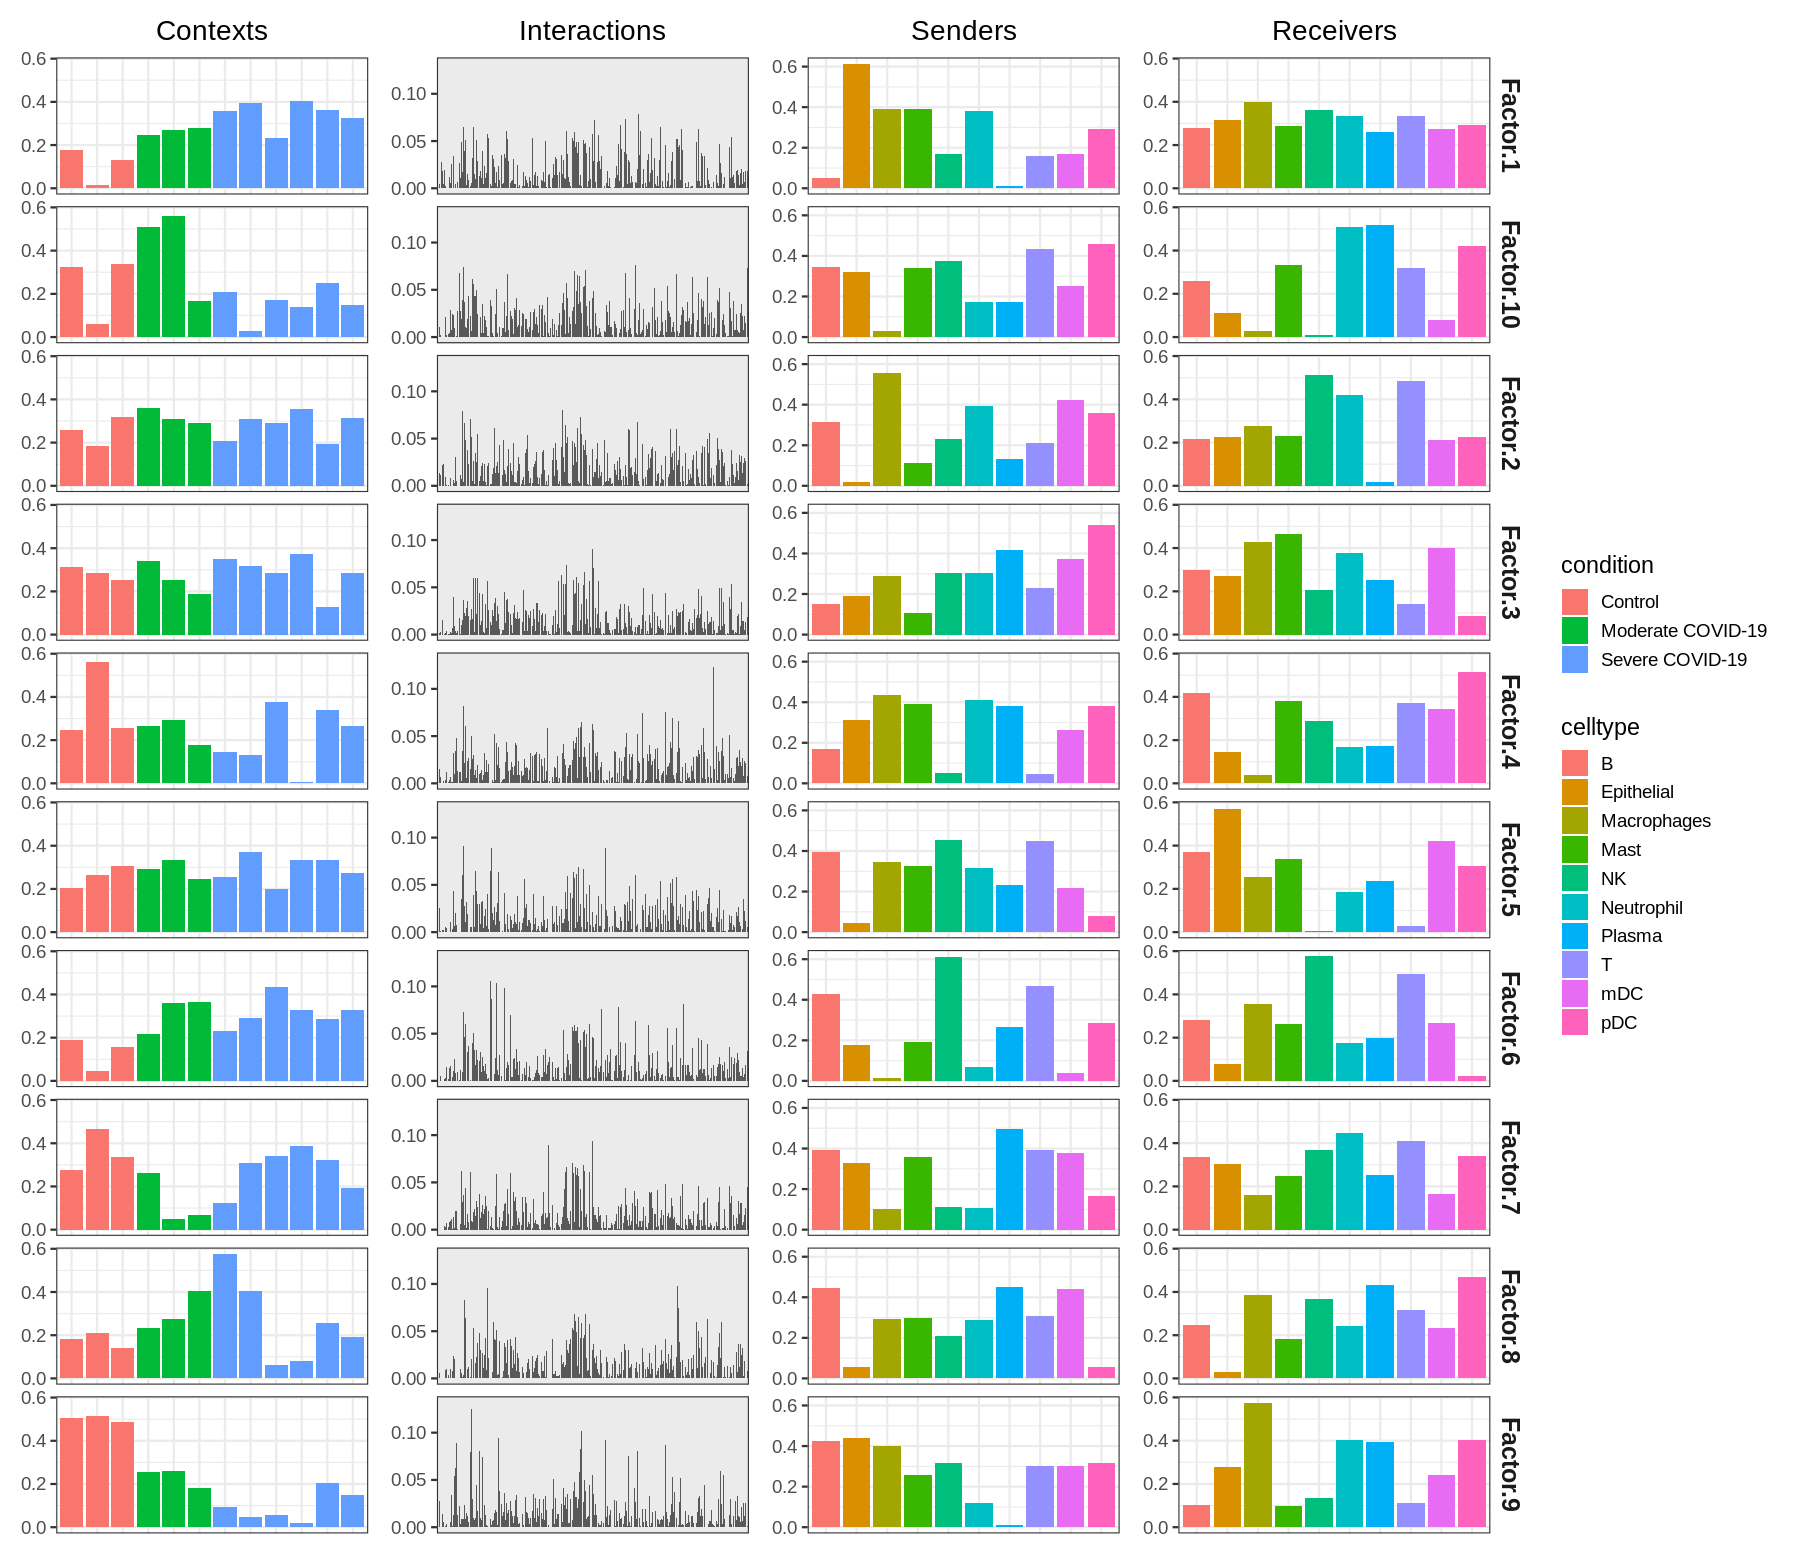

In [88]:
h_ = 13
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

plot_c2c_overview(sce = covid_data, group_col = 'condition', sample_col = 'sample_new')

## Factorization Results

After running the decomposition, the results are stored in the `factors` attribute (`tensor$factors`). This attribute is a dictionary (named list) containing the loadings for each of the elements in every tensor dimension. Keys are the names of the different dimension.

In [57]:
names(tensor$factors)

[1] "contexts"     "interactions" "senders"      "receivers"

We can inspect the loadings of the samples, for example, located under the key `'Contexts'`.

In [59]:
tensor$factors[['contexts']]

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HC1,0.17684251,0.2582754,0.3133827,0.246032000,0.2045761,0.19070311,0.27581340,0.18096028,0.50578725,0.32275069
HC2,0.01499927,0.1859038,0.2857483,0.563847423,0.2659419,0.04456013,0.46525121,0.21105924,0.51340425,0.06077319
HC3,0.12987597,0.3200001,0.2522247,0.257546365,0.3058413,0.15871561,0.33408451,0.14133932,0.48707247,0.33845034
M1,0.24734376,0.3605677,0.3412610,0.265900016,0.2911368,0.21589598,0.26425526,0.23229212,0.25350636,0.50919831
M2,0.27078003,0.3112310,0.2546913,0.293017715,0.3316287,0.35877320,0.05096542,0.27653542,0.26122975,0.55960810
M3,0.27792311,0.2921827,0.1899005,0.176158667,0.2435903,0.36659488,0.07013979,0.40399924,0.18296535,0.16596934
S1,0.35934332,0.2060984,0.3504963,0.142922312,0.2537487,0.22913800,0.12354568,0.57704484,0.09159108,0.20734781
S2,0.39395842,0.3080244,0.3173108,0.131685734,0.3707642,0.29019293,0.31005719,0.40421811,0.04767059,0.02758168
S3,0.23484014,0.2888687,0.2828363,0.377590060,0.2015683,0.43683028,0.34173292,0.06321815,0.05551106,0.17058332


If we are interested in the top elements of a given dimension, here for example `'interactions'`, we can easily obtain them:

In [62]:
tensor$get_top_factor_elements(order_name='interactions', 
                                factor_name='Factor 10', 
                                top_number=as.integer(10))

ARF6^PLD1       IRAK4^TLR7       COPA^P2RY6     ADAM28^ITGA4 
      0.12582886       0.12007568       0.11308899       0.09736333 
         PTN^NCL     HSP90B1^TLR7 TNFSF13^TNFRSF14      SELPLG^SELL 
      0.09462333       0.08812299       0.08603955       0.08449654 
       APP^LRP10       APP^NOTCH2 
      0.08352185       0.08229310

## Supplementary Information about the Tensor Decomposition

The tensor decomposition performed here is a non-negative canonical polyadic decomposition (CPD) (same performed in the elbow analysis). Briefly, tensor decomposition identifies a low-rank tensor (here, a rank of 10) that approximated the full tensor. This low-rank tensor can be represented as the sum of a set of rank-1 tensors (10 of them in this case). Each rank-1 tensor represents a factor in the decomposition and can be further represented as the outer product of n vectors, where n represents the number of tensor dimensions. Each vector represents one of the n tensor dimensions for that factor and its values, corresponding to individual elements in each dimension, represent the factor loadings. In our case, each factor will contain loadings for the context, LR pair, sender-cell, and receiver-cell dimensions. Those elements within each factor that contain high loadings contribute to the factor-specific communication pattern.

![TF](https://earmingol.github.io/cell2cell/tutorials/ASD/figures/tensor-factorization.png)

### Subset of a Tensor


From this analysis we may also be interested in a subset of the original tensor to inspect the cell-cell communication of a subset of samples, LR pairs, sender cells, or receiver cells.

We can subset the original tensor without having to build it from the beginning. For example, we are interested in the CCC of NKs and T cells as the senders, and B cells, Macrophages, mDC and pDC cells as receivers. We can do so by creating a dictionary specifying the elements of the dimensions that we want to subset. Here, the dimensions corresponds to:
- `0` for the Contexts
- `1` for the Ligand-Receptor Pairs
- `2` for the Sender Cells
- `3` for the Receiver Cells

If we do not include a dimension in the following dictionary, that dimension will not be subset.

In [74]:
sender_subset = list('NK', 'T')
receiver_subset = list('B', 'Macrophages', 'mDC', 'pDC')

subset_dict<-reticulate::py_dict(keys = c(as.integer(2), as.integer(3)), 
                                 values = list(sender_subset, receiver_subset))
subset_dict

{2: ['NK', 'T'], 3: ['B', 'Macrophages', 'mDC', 'pDC']}

Some key parameters here are:

- `original_order` indicates whether keeping the element order as in the original tensor or as in the subset list.

- `remove_duplicates` indicates whether removing duplicate elements in the subset lists. Duplicates can be introduced especially when passing these lists manually.

- `keep` indicates what duplicated element to keep. Options are:
    - 'first' : Drop duplicates except for the first occurrence.
    - 'last' : Drop duplicates except for the last occurrence.
    - False : Drop all duplicates.

In [75]:
subset_tensor = c2c$tensor$subset_tensor(interaction_tensor=tensor, 
                        subset_dict=subset_dict, 
                        original_order=TRUE)

If we compare the size of the original tensor with the subset one, we can see that we only modified the senders and receiver cells.

In [87]:
print(tensor$tensor$shape)
print(subset_tensor$tensor$shape)

torch.Size([12, 1419, 10, 10])
torch.Size([12, 1419, 2, 4])
